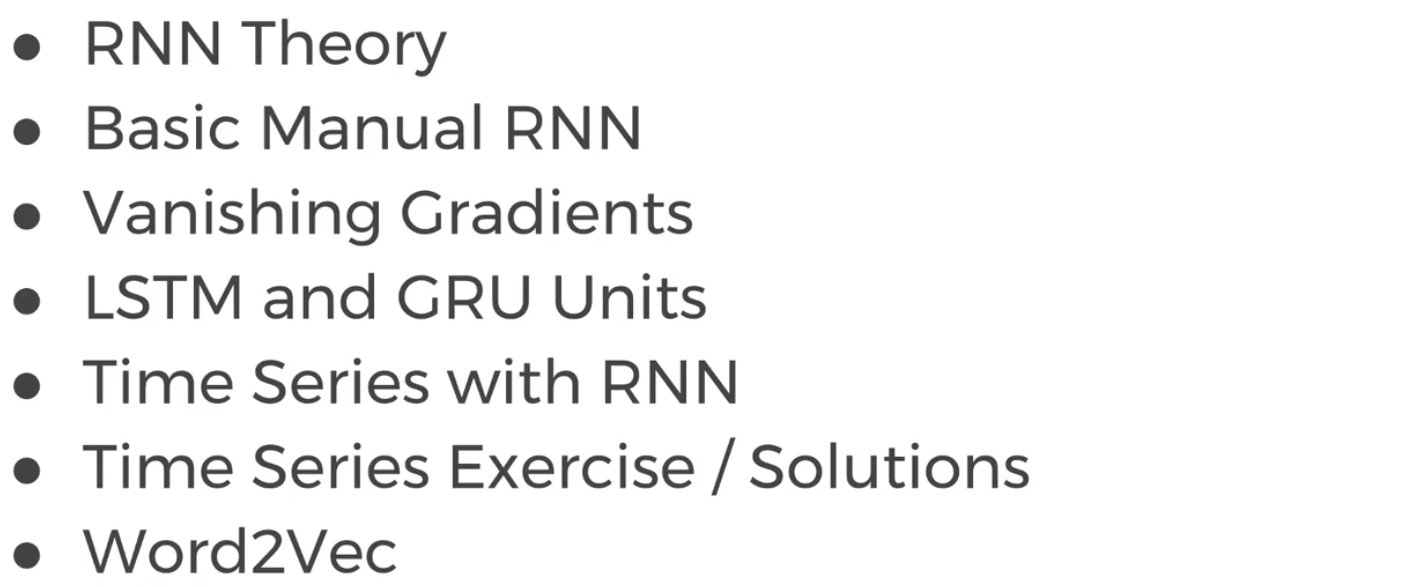

# Recurrent Neural Network Theory

* Sequence Information
* Time Series  
* Natural Language - Sequence of Words  
* Music  
* Car Trajectory

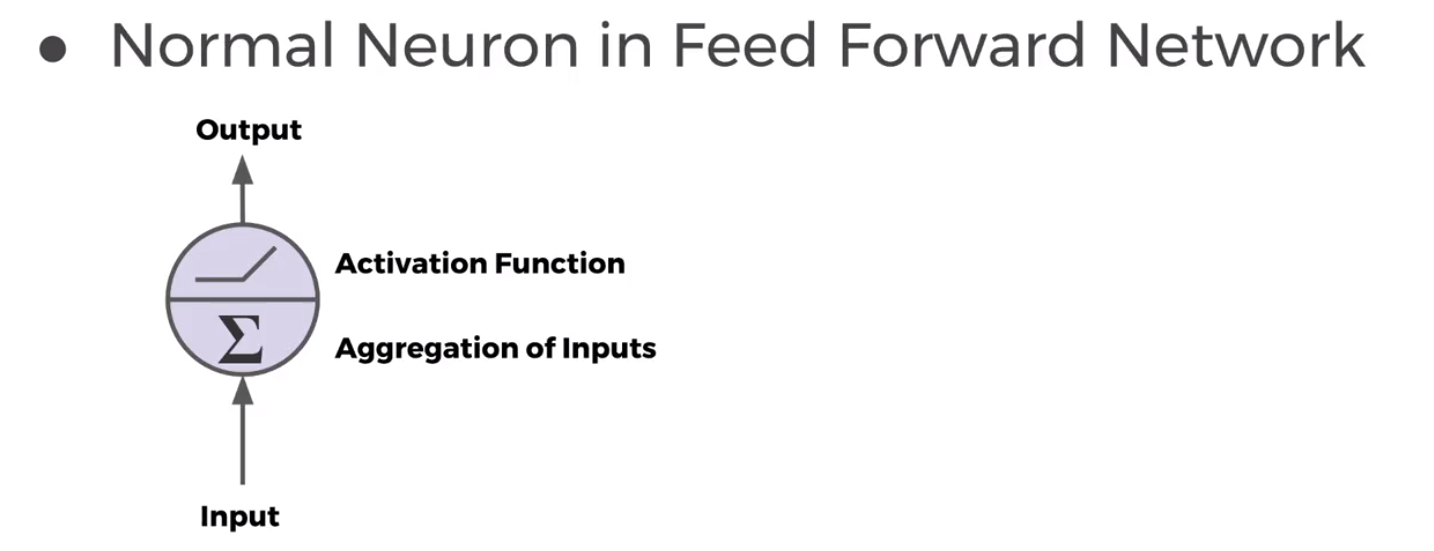

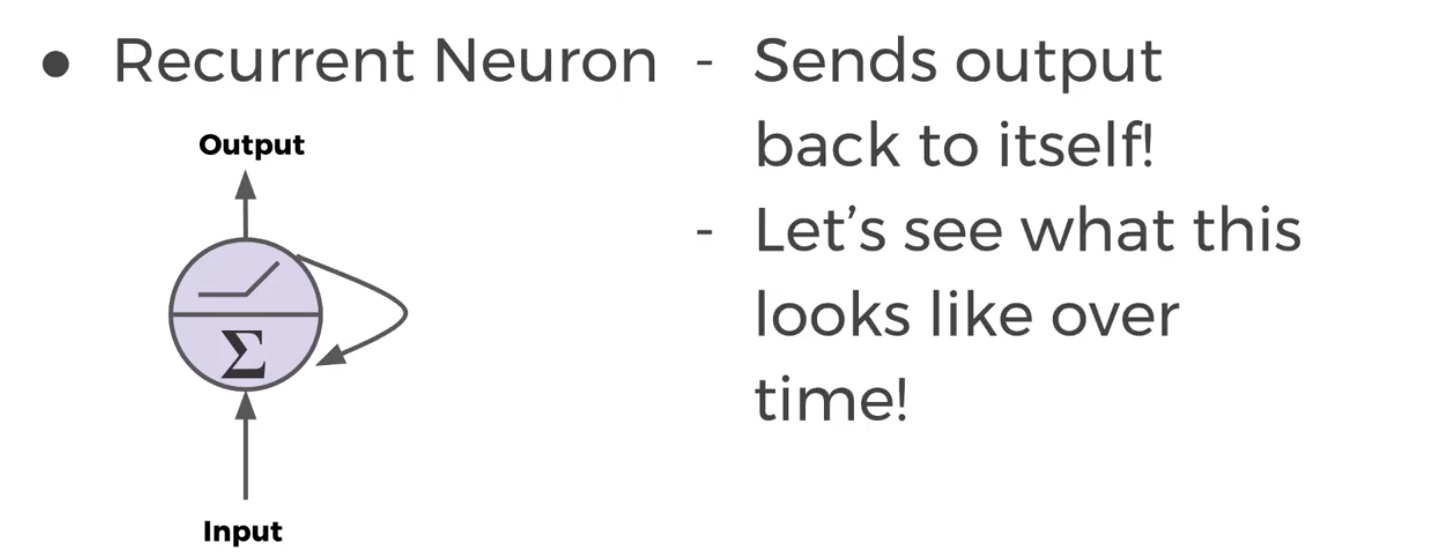

Unrolling the recurrent neuron throughout time

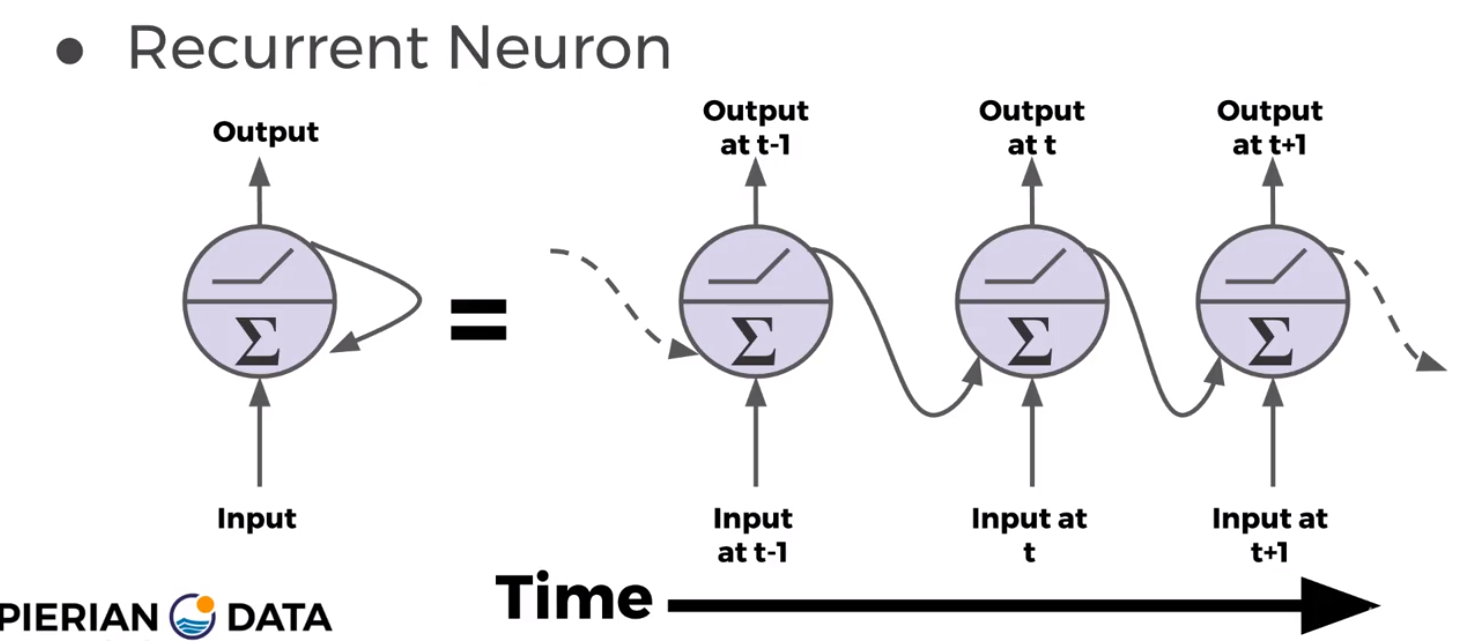

Cells that are a funciton of inputs from previous time steps are called memory cells.  


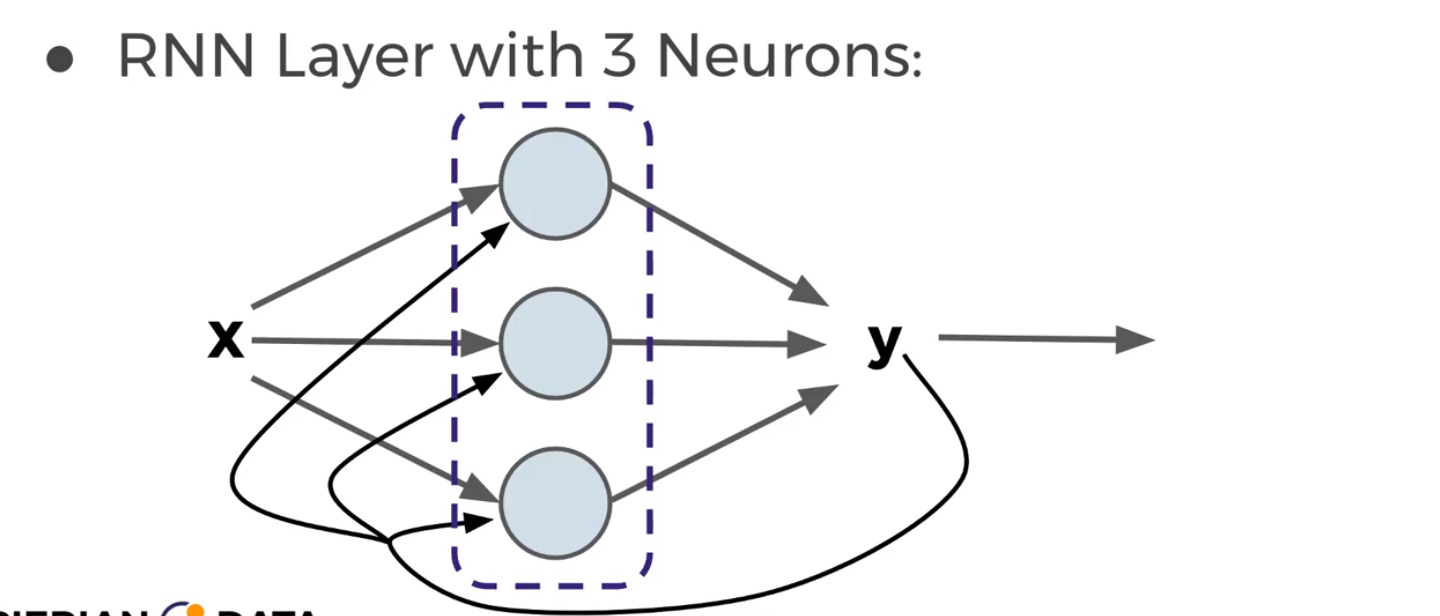

Possible inputs to outputs:  
* Sequence to Sequence - e.g. Time Series  
* Sequence to Vector - e.g. Word sequence -> Sentiment  
* Vector to Sequence - e.g. Picture to Caption

# Manual RNN with TF

Creating 3 neuron RNN layer with TensorFlow

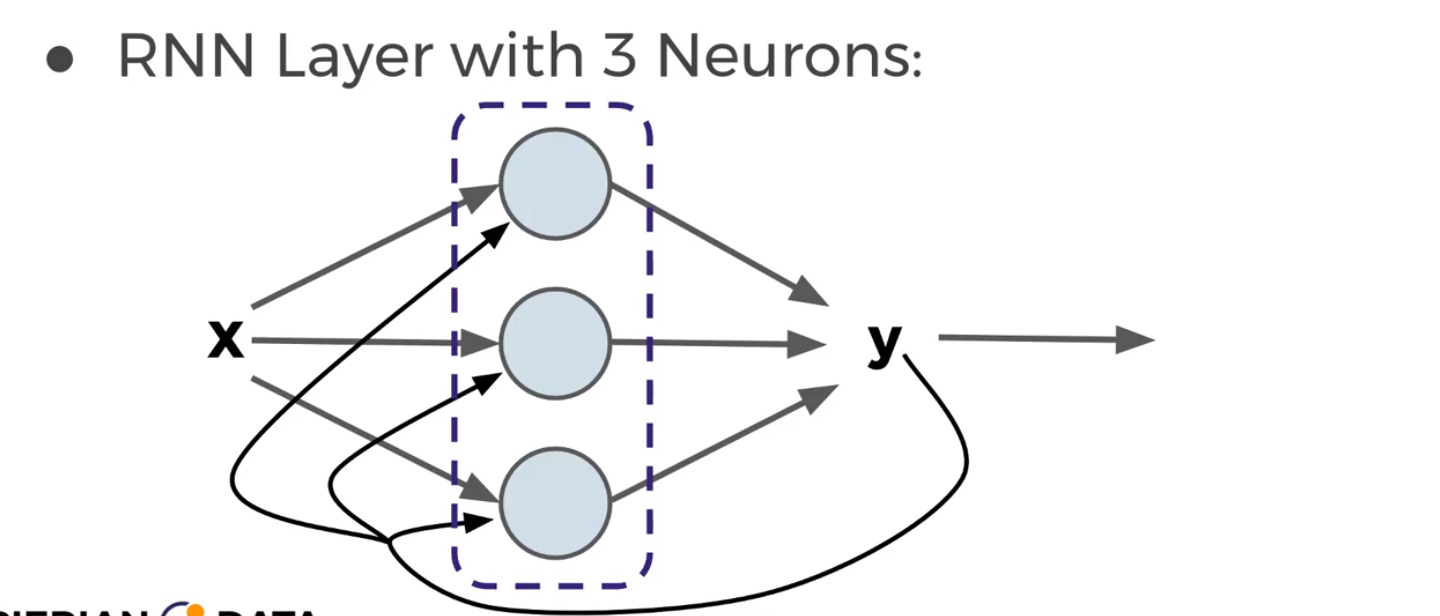

### Format of Input Data

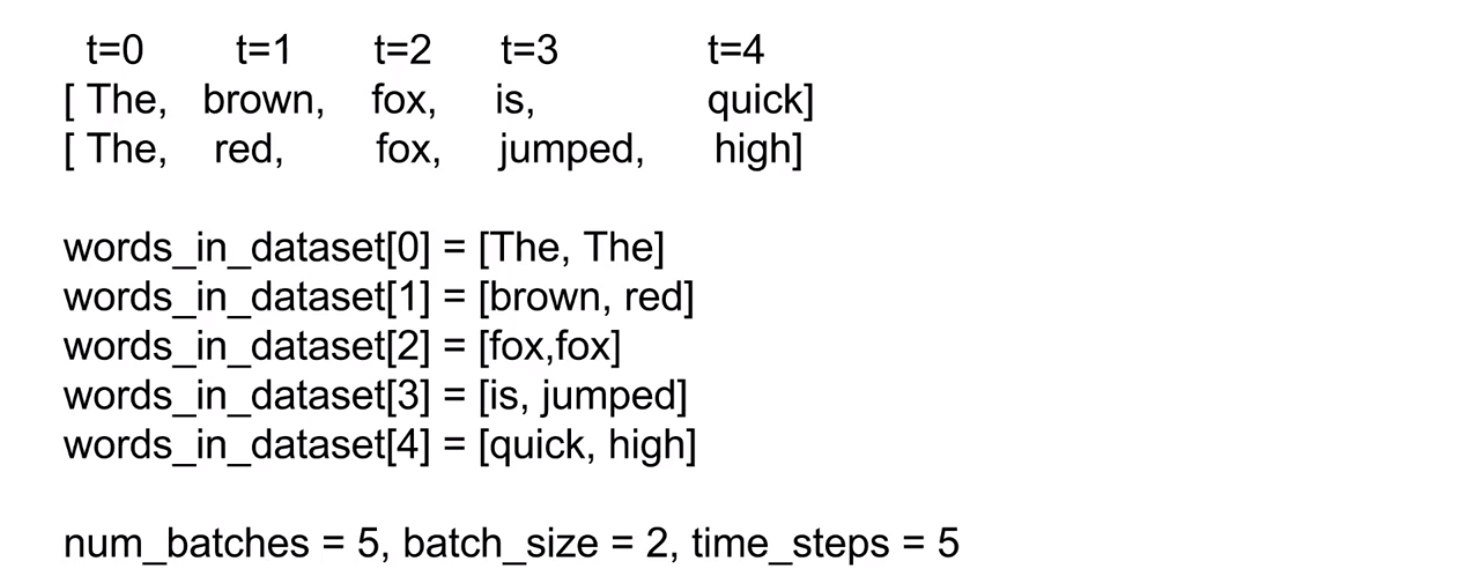

Feed batches by timesteps.  
2 batches of data.  
5 total timesteps. 

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

### Constants

In [2]:
num_inputs = 2
num_neurons = 3

### Placeholders

In [3]:
x0 = tf.placeholder(tf.float32,[None,num_inputs])
x1 = tf.placeholder(tf.float32,[None,num_inputs])

### Variables

In [4]:
Wx = tf.Variable(tf.random_normal(shape=[num_inputs,num_neurons]))

In [5]:
Wx.shape

TensorShape([Dimension(2), Dimension(3)])

In [6]:
Wy = tf.Variable(tf.random_normal(shape=[num_neurons,num_neurons]))

In [7]:
b = tf.Variable(tf.zeros([1,num_neurons]))

### Graphs

In [8]:
y0 = tf.tanh(tf.matmul(x0,Wx) + b)

In [9]:
y1 = tf.tanh(tf.matmul(y0,Wy) + tf.matmul(x1,Wx) + b)

In [10]:
init = tf.global_variables_initializer()

### Create Data

In [11]:
# TIMESTAMP 0
x0_batch = np.array([ [0,1], [2,3] , [4,5] ])

# TIMESTAMP 1
x1_batch = np.array( [ [100,101] , [102,103] , [104,105] ])

In [12]:
with tf.Session() as sess:
    
    sess.run(init)
    
    y0_output_vals,y1_output_vals = sess.run([y0,y1],feed_dict={x0:x0_batch,x1:x1_batch})

In [13]:
y0_output_vals

array([[ 0.23866273,  0.63398731, -0.49141219],
       [-0.93681228,  0.99672097, -0.97158164],
       [-0.99869251,  0.99997604, -0.9987821 ]], dtype=float32)

In [14]:
y1_output_vals

array([[-1.,  1., -1.],
       [-1.,  1., -1.],
       [-1.,  1., -1.]], dtype=float32)

# Vanishing Gradients

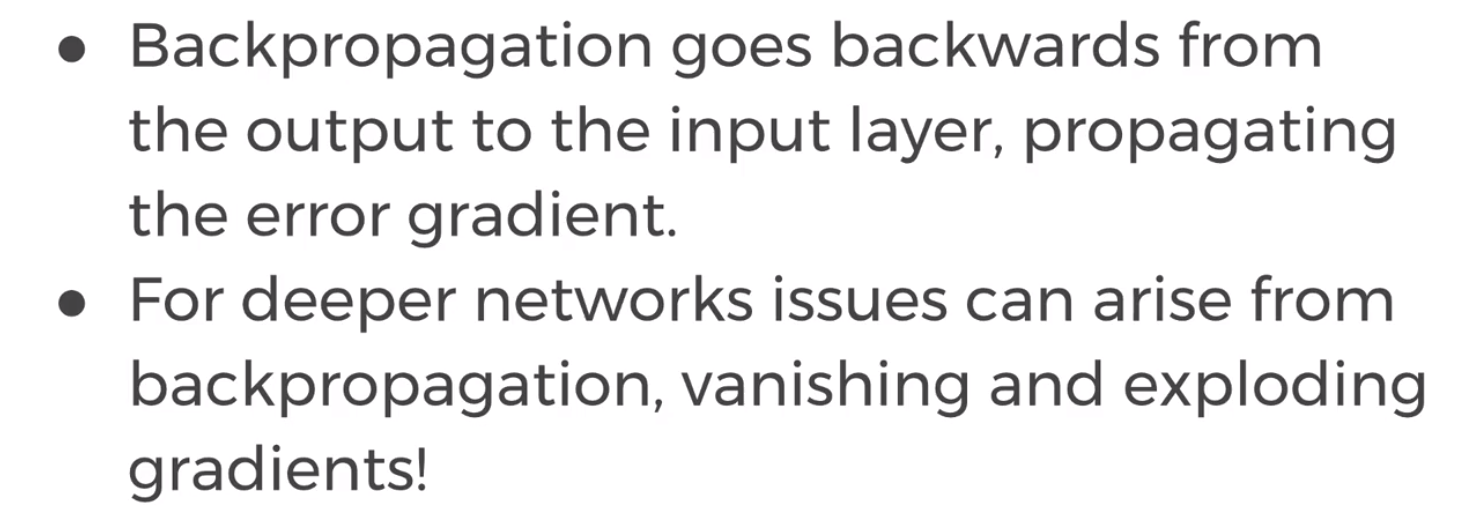

Backpropagation has weak influnce on weights in early layers of a deep neural net

LSTM and GRU as potential solutions

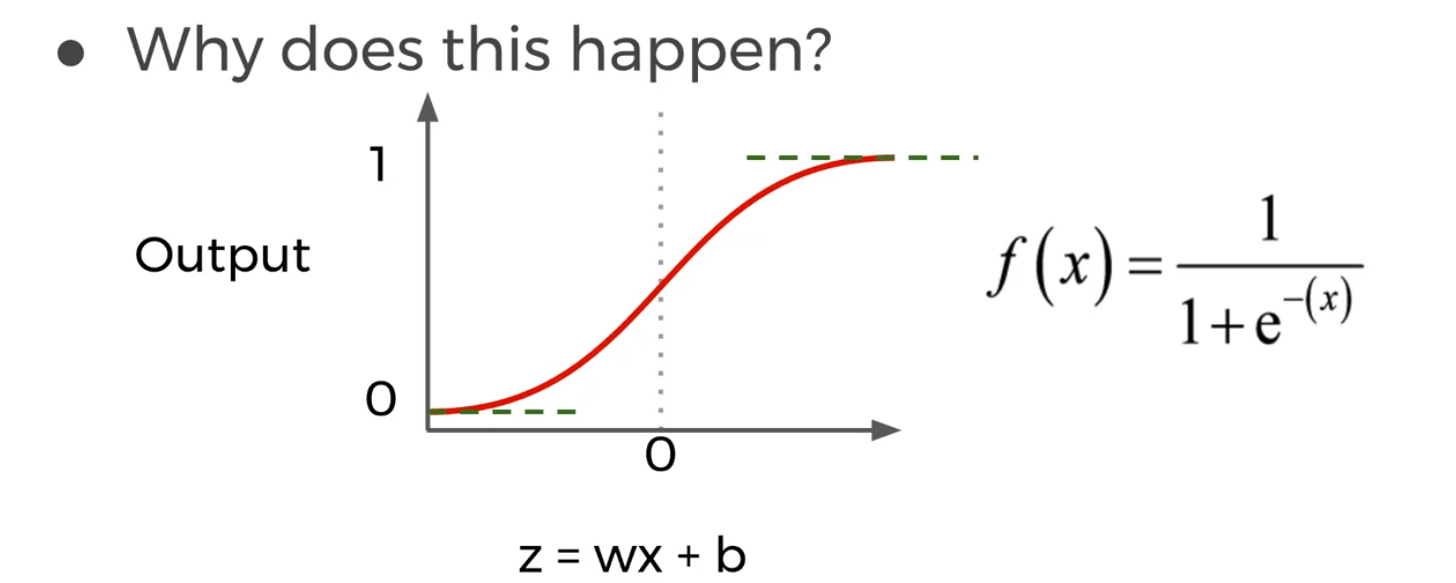

Backpropagation computes the gradients by the chain rule. Small numbers are repeatedly multiplied by exponentially smaller numbers in backpropagation. 

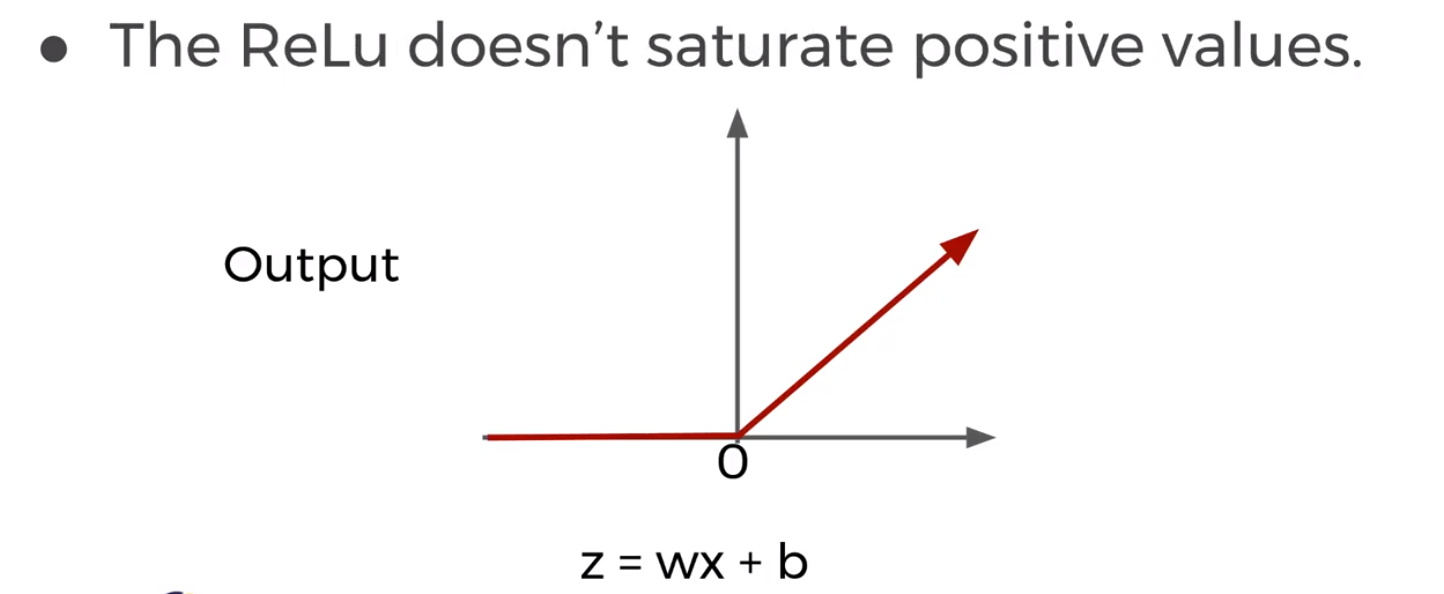

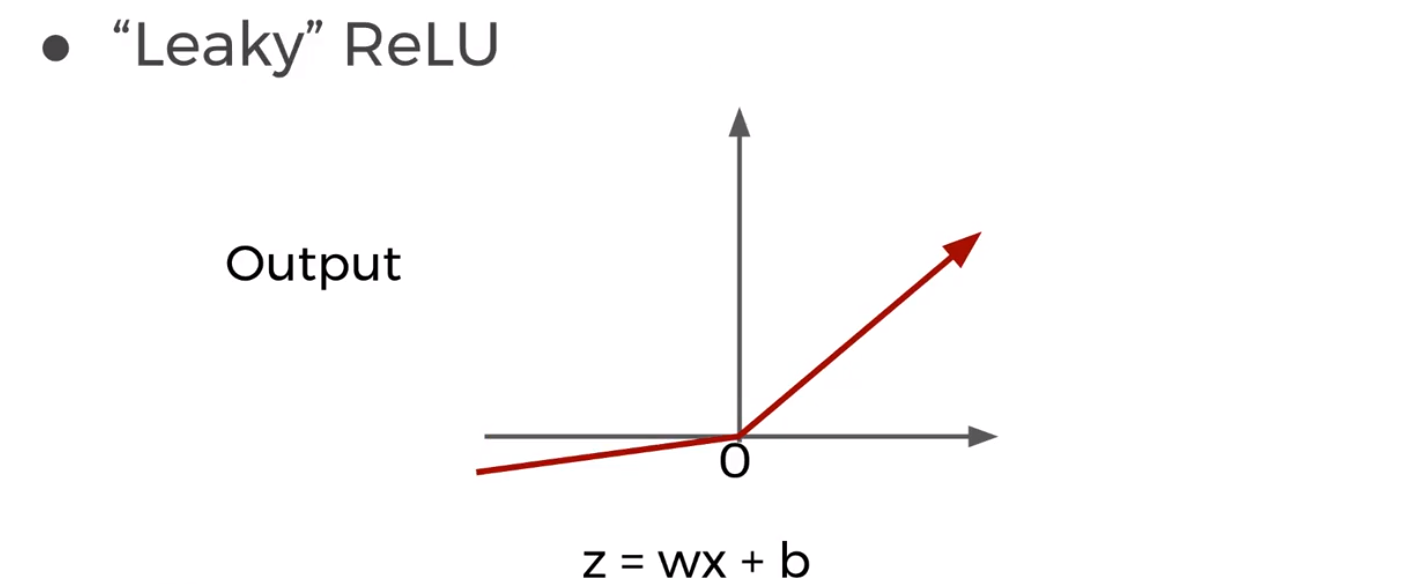

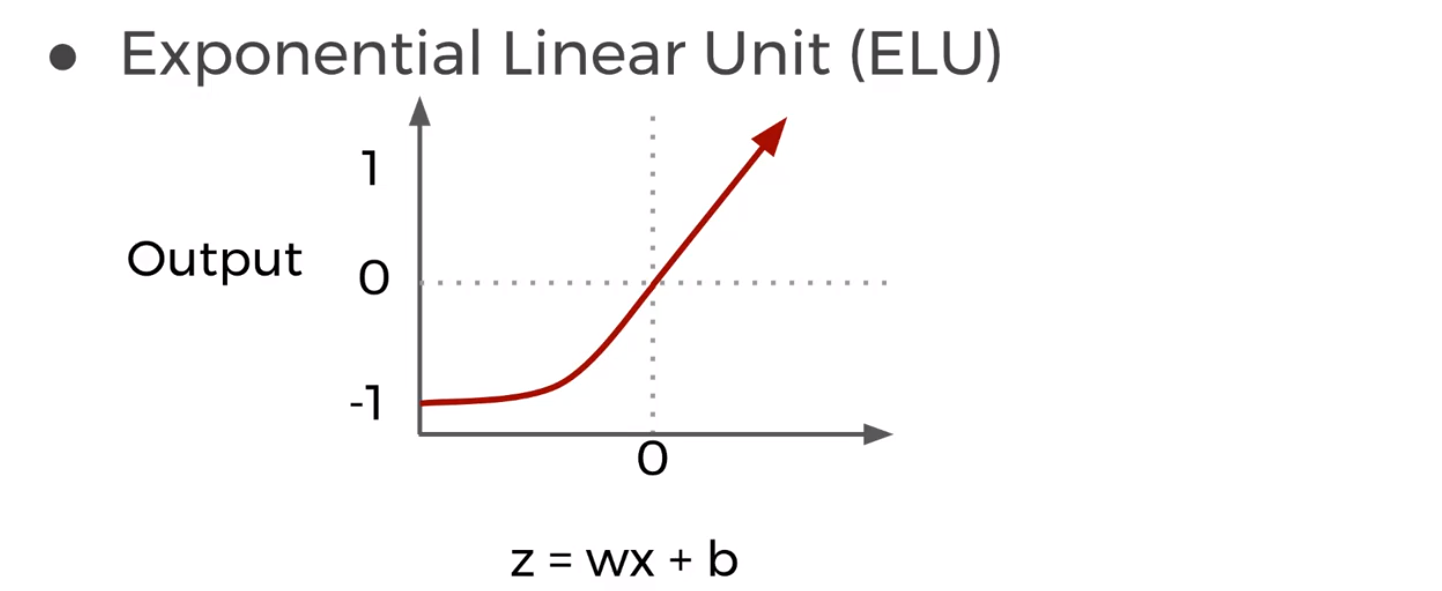

Using these activation functions, the gradients do not vanish. 

Other solutions to vanishing gradients:  
* Batch Normalization  
* Gradient Clipping

# LSTM Theory

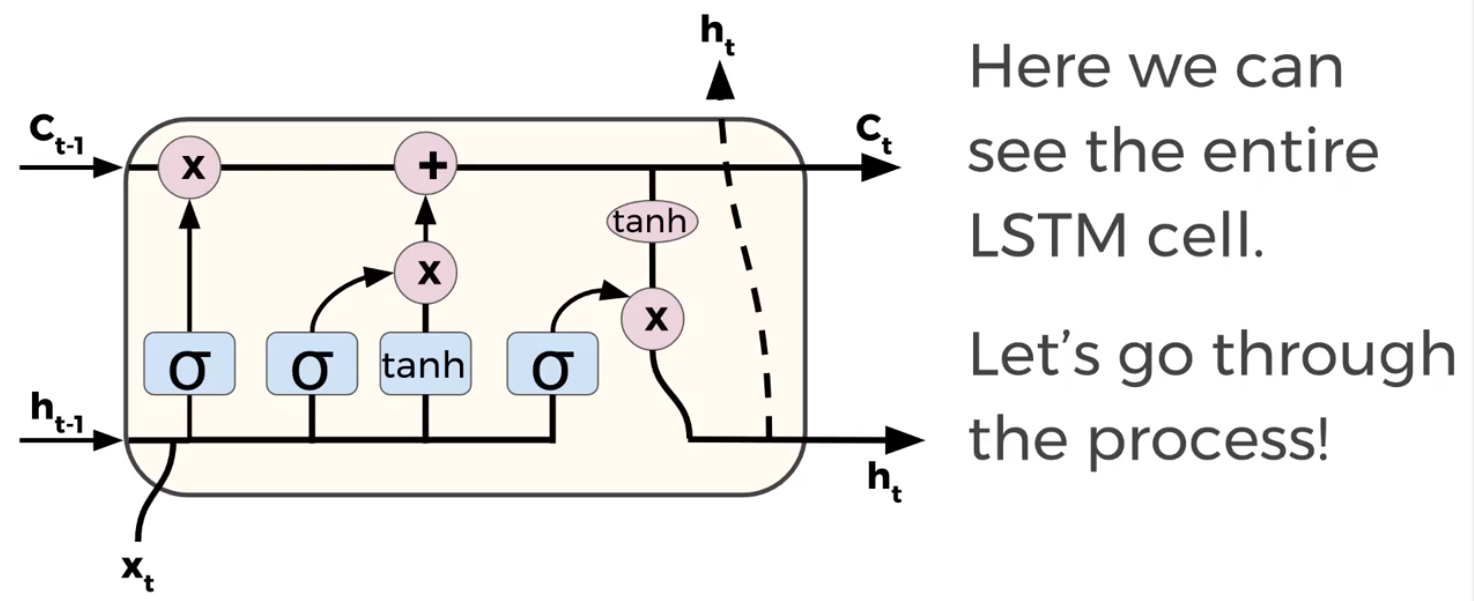

# GRU Theory

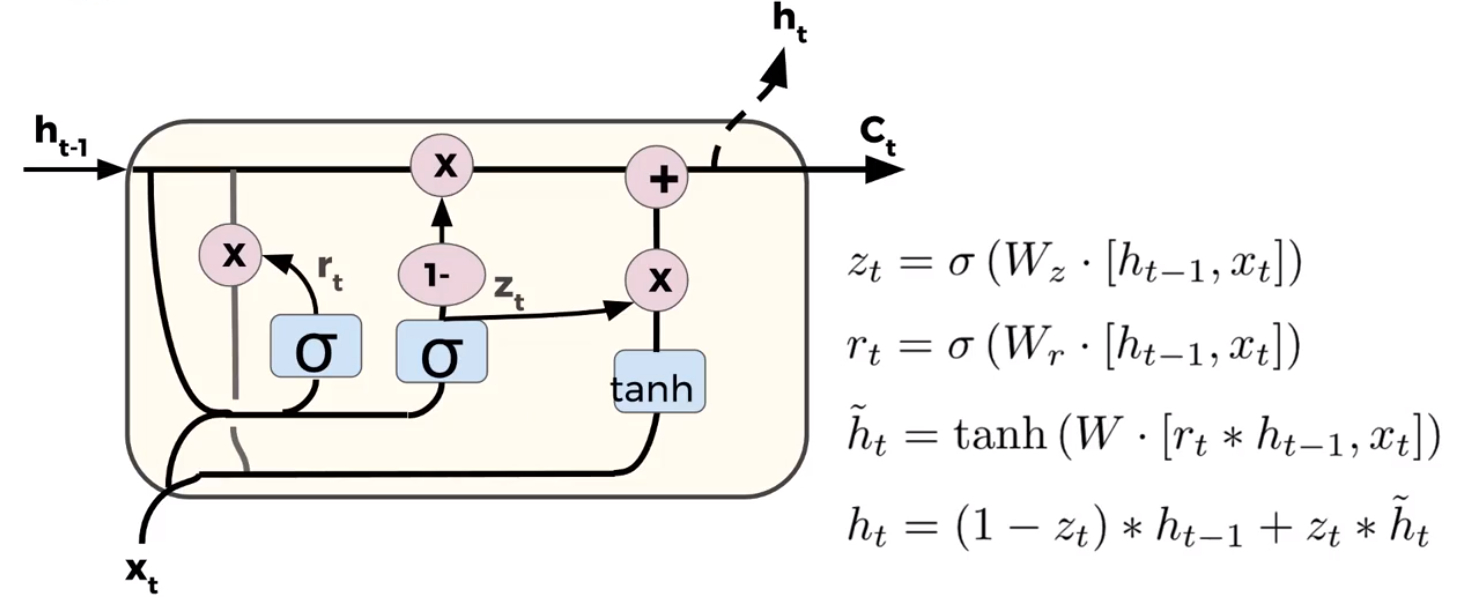

GRU has simpler architecture, so it has become more popular in recent times. 

In [15]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
class TimeSeriesData():
    
    def __init__(self,num_points,xmin,xmax):
        
        self.xmin = xmin
        self.xmax = xmax
        self.numpoints = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data = np.linspace(xmin,xmax,num_points)
        self.y_true = np.sin(self.x_data)
        
    def ret_true(self,x_series):
        return np.sin(x_series)
    
    def next_batch(self,batch_size,steps,return_batch_ts=False):
        
        # Grab a random starting point for each batch
        rand_start = np.random.rand(batch_size,1)
        
        # Convert to be on time series
        ts_start = rand_start * (self.xmax - self.xmin - (steps*self.resolution))
        
        # Create batch time series on the x axis
        batch_ts = ts_start + np.arange(0.0,steps+1) * self.resolution       
        
        # Create the Y data for the time series x axis from previous step
        y_batch = np.sin(batch_ts)
        
        # Formatting for RNN
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1), batch_ts
        else:
            return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1)

In [17]:
ts_data = TimeSeriesData(250,0,10)

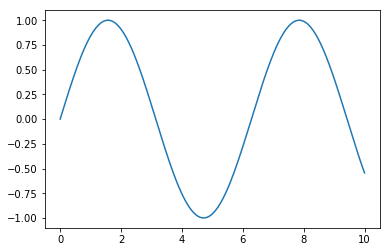

In [18]:
plt.plot(ts_data.x_data,ts_data.y_true)

In [19]:
num_time_steps = 30

In [20]:
y1,y2,ts = ts_data.next_batch(1,num_time_steps,True)

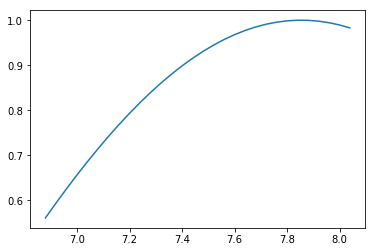

In [21]:
plt.plot(ts.flatten()[1:],y2.flatten())

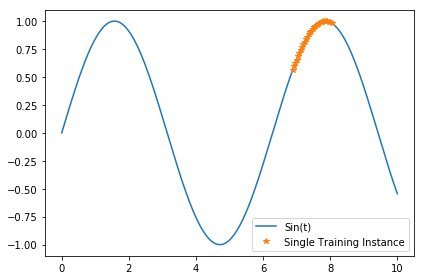

In [22]:
plt.plot(ts_data.x_data,ts_data.y_true,label='Sin(t)')
plt.plot(ts.flatten()[1:],y2.flatten(),'*',label='Single Training Instance')

plt.legend()
plt.tight_layout()

## Training Data

In [23]:
train_inst = np.linspace(5,5 + ts_data.resolution*(num_time_steps+1),num_time_steps+1)

In [24]:
train_inst

array([ 5.        ,  5.04133333,  5.08266667,  5.124     ,  5.16533333,
        5.20666667,  5.248     ,  5.28933333,  5.33066667,  5.372     ,
        5.41333333,  5.45466667,  5.496     ,  5.53733333,  5.57866667,
        5.62      ,  5.66133333,  5.70266667,  5.744     ,  5.78533333,
        5.82666667,  5.868     ,  5.90933333,  5.95066667,  5.992     ,
        6.03333333,  6.07466667,  6.116     ,  6.15733333,  6.19866667,
        6.24      ])

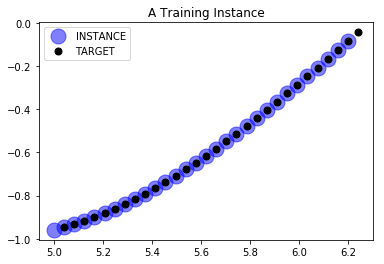

In [25]:
plt.title('A Training Instance')

plt.plot(train_inst[:-1],ts_data.ret_true(train_inst[:-1]),
         'bo',markersize=15,alpha=0.5,label='INSTANCE')
plt.plot(train_inst[1:],ts_data.ret_true(train_inst[1:]),
         'ko',markersize=7,label='TARGET')

plt.legend()

Given these blue points, can you predict the black points?

# Creating the RNN Model

In [26]:
tf.reset_default_graph()

In [27]:
num_inputs = 1

num_neurons = 100

num_outputs = 1

learning_rate = 0.0001

num_train_iterations = 2000

batch_size = 1

### Placeholders

In [28]:
X = tf.placeholder(tf.float32,[None,num_time_steps,num_inputs])
y = tf.placeholder(tf.float32,[None,num_time_steps,num_outputs])

### RNN Cell Layer

In [29]:
cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.GRUCell(num_units=num_neurons,activation=tf.nn.relu)
                                              ,output_size=num_outputs)

In [30]:
outputs,states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

### Mean Squared Error

In [31]:
loss = tf.reduce_mean(tf.square(outputs-y))

In [32]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [33]:
train = optimizer.minimize(loss)

In [34]:
init = tf.global_variables_initializer()

### Session

In [35]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.85)

In [36]:
saver = tf.train.Saver()

In [37]:
with tf.Session(config = tf.ConfigProto(gpu_options=gpu_options)) as sess:
    
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        X_batch, y_batch = ts_data.next_batch(batch_size,num_time_steps)
        
        sess.run(train,feed_dict={X:X_batch,y:y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X:X_batch,y:y_batch})
            print(iteration,"\tMSE",mse)
            
    saver.save(sess,"./my_first_rnn_model")

0 	MSE 0.559489
100 	MSE 0.226124
200 	MSE 0.0903683
300 	MSE 0.0226783
400 	MSE 0.139446
500 	MSE 0.0173417
600 	MSE 0.0940206
700 	MSE 0.0618916
800 	MSE 0.0822455
900 	MSE 0.023704
1000 	MSE 0.0667995
1100 	MSE 0.00203013
1200 	MSE 0.0415835
1300 	MSE 0.029501
1400 	MSE 0.0220813
1500 	MSE 0.0351175
1600 	MSE 0.0191837
1700 	MSE 0.00734801
1800 	MSE 0.0293789
1900 	MSE 0.0019494


In [38]:
with tf.Session() as sess:
    
    saver.restore(sess,'./my_first_rnn_model')
    
    X_new = np.sin(np.array(train_inst[:-1].reshape(-1,num_time_steps,num_inputs)))
    y_pred = sess.run(outputs,feed_dict={X:X_new})

INFO:tensorflow:Restoring parameters from ./my_first_rnn_model


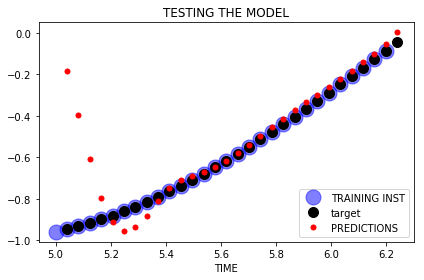

In [39]:
plt.title('TESTING THE MODEL')

plt.plot(train_inst[:-1],np.sin(train_inst[:-1]),"bo",markersize=15,alpha=0.5,label='TRAINING INST')

plt.plot(train_inst[1:],np.sin(train_inst[1:]),'ko',markersize=10,label='target')

plt.plot(train_inst[1:],y_pred[0,:,0],'r.',markersize=10,label='PREDICTIONS')

plt.xlabel('TIME')
plt.legend()
plt.tight_layout()

# Generating New Sequence

In [40]:
with tf.Session() as sess:
    
    saver.restore(sess, './my_first_rnn_model')
    
    zero_seq_seed = [0.0 for i in range(num_time_steps)]
    
    for iteration in range(len(ts_data.x_data)-num_time_steps):
        
        X_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1,num_time_steps,1)
        
        y_pred = sess.run(outputs,feed_dict={X:X_batch})
        
        zero_seq_seed.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./my_first_rnn_model


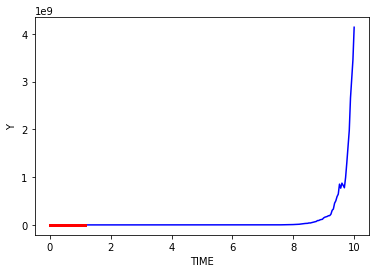

In [41]:
plt.plot(ts_data.x_data,zero_seq_seed,'b-')
plt.plot(ts_data.x_data[:num_time_steps],zero_seq_seed[:num_time_steps],'r',linewidth=3)
plt.xlabel('TIME')
plt.ylabel('Y')